In [27]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [28]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [29]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect
from flask import Flask, jsonify

In [30]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [31]:
# reflect an existing database into a new model
Base=automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [32]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [33]:
# Save references to each table
Measurement=Base.classes.measurement
Station=Base.classes.station

In [34]:
# Create our session (link) from Python to the DB
session=Session(engine)

# Exploratory Precipitation Analysis

In [35]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

In [36]:
inspector = inspect(engine)
inspector.get_table_names()

columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])
columns

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


[{'name': 'id',
  'type': INTEGER(),
  'nullable': False,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 1},
 {'name': 'station',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'date',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'prcp',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'tobs',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0}]

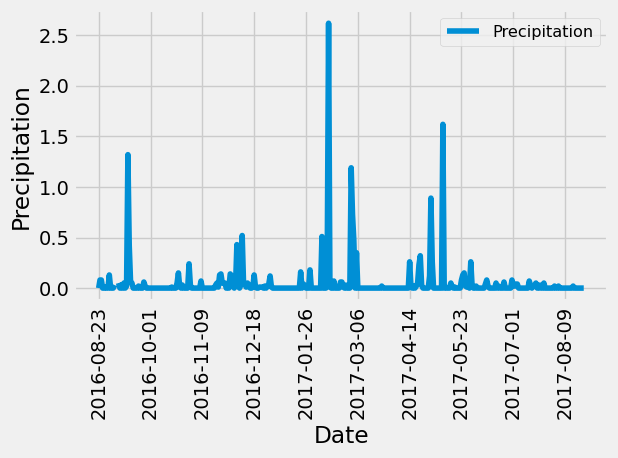

In [37]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
session.query(Measurement.date).order_by(Measurement.date).first()
year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
year_ago
# Calculate the date one year from the last date in data set.
sel=[Measurement.date,Measurement.prcp]
year_prcp=session.query(*sel).\
    filter((Measurement.date)>=year_ago).filter((Measurement.date)<=dt.date(2017,8,23)).\
    group_by(Measurement.date).\
    order_by(Measurement.date).all()
# Perform a query to retrieve the data and precipitation scores
year_prcp

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df=pd.DataFrame(year_prcp,columns=['Date','Precipitation'])
precipitation_df['Date']=pd.to_datetime(precipitation_df['Date'])
precipitation_df = precipitation_df.sort_values(by='Date')
precipitation_df
# Sort the dataframe by date. https://stackoverflow.com/questions/10557614/matplotlib-figlegend-only-printing-first-letter used to fix legend so it shows more than the first letter.
plt.plot(precipitation_df['Date'],precipitation_df['Precipitation'])
tick_interval=39
plt.xticks(precipitation_df['Date'][::tick_interval],rotation=90)
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.legend(('Precipitation',),loc='upper right',fontsize='small')
plt.tight_layout()
plt.show()

# Use Pandas Plotting with Matplotlib to plot the data


In [38]:
precipitation_df.head()

,Date,Precipitation
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


In [39]:
# Use Pandas to calculate the summary statistics for the precipitation data
print(precipitation_df.describe())

       Precipitation
count     364.000000
mean        0.048709
std         0.204930
min         0.000000
25%         0.000000
50%         0.000000
75%         0.020000
max         2.620000


# Exploratory Station Analysis

In [40]:
# Design a query to calculate the total number of stations in the dataset
inspector = inspect(engine)
inspector.get_table_names()

columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])
columns
session.query(func.count(Station.station)).all()
station_list=session.query(Station.station).all()
station_list

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


[('USC00519397',),
 ('USC00513117',),
 ('USC00514830',),
 ('USC00517948',),
 ('USC00518838',),
 ('USC00519523',),
 ('USC00519281',),
 ('USC00511918',),
 ('USC00516128',)]

In [41]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
session.query(Measurement.station,func.count(Measurement.tobs)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [42]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter((Measurement.station)=='USC00519281').all()


[(54.0, 85.0, 71.66378066378067)]

In [43]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel=[Measurement.date,Measurement.tobs]
year_temps=session.query(*sel).filter(Measurement.station=='USC00519281').\
    filter((Measurement.date)>=year_ago).filter((Measurement.date)<=dt.date(2017,8,23)).\
    group_by(Measurement.date).\
    order_by(Measurement.date).all()
station_temp_df=pd.DataFrame(year_temps,columns=['Date','TOBS'])
station_temp_df['Date']=pd.to_datetime(station_temp_df['Date'])
station_temp_df = station_temp_df.sort_values(by='Date')
station_temp_df

,Date,TOBS
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0
...,...,...
347,2017-08-14,77.0
348,2017-08-15,77.0
349,2017-08-16,76.0
350,2017-08-17,76.0


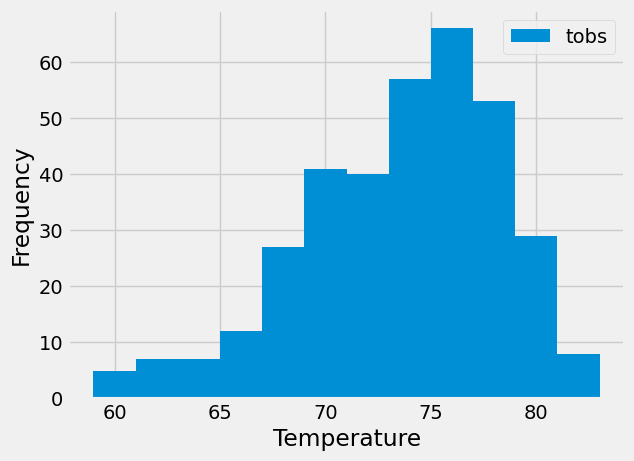

In [44]:
#Histogram portion
fig,ax=plt.subplots()
ax.hist(station_temp_df['TOBS'],bins=12)
ax.set_xlabel('Temperature')
ax.set_ylabel('Frequency')
ax.legend(('tobs',),loc='upper right')

# Close Session

In [45]:
# Close Session
session.close()

Design the climate app

In [46]:
# Start at the homepage
app = Flask(__name__)

In [47]:
#List all available routes
@app.route("/")
def welcome():
    return (
        f"Welcome to the Climate API!<br/>"
        f"Available Routes:<br/>"
        f"/api/v1.0/precipitation:<br/>"
        f"/api/v1.0/stations:<br/>"
        f"/api/v1.0/tobs:<br/>"
        f"/api/v1.0/<start>:<br/>"
        f"/api/v1.0/<start>/<end>:<br/>")

In [48]:
#Convert query results to a dictionary.
prcp_dict={}
for i,row in precipitation_df.iterrows():
    key=row['Date']
    value=row['Precipitation']
    prcp_dict[key]=value

#Return the JSON representation of the dictionary.
@app.route("/api/v1.0/precipitation")
def precipitation_route():
    """Return the precipitation data as json"""

    return jsonify(prcp_dict)

In [49]:
#Return a JSON list of stations from the dataset.
@app.route("/api/v1.0/stations")
def station_route():
    """Return the station data as json"""

    return json.dumps(station_list)

In [50]:
#Query the dates and temperature observations of the most active station for the previous year of data.
sel=[Measurement.date,Measurement.tobs]
year_temps=session.query(*sel).filter(Measurement.station=='USC00519281').\
    filter((Measurement.date)>=year_ago).filter((Measurement.date)<=dt.date(2017,8,23)).\
    group_by(Measurement.date).\
    order_by(Measurement.date).all()
station_temp_df=pd.DataFrame(year_temps,columns=['Date','TOBS'])
station_temp_df['Date']=pd.to_datetime(station_temp_df['Date'])
station_temp_df = station_temp_df.sort_values(by='Date')
station_temp_df
#Return a JSON list of temperature observations for the previous year.
@app.route("/api/v1.0/tobs")
def tobs_route():
    """Return the most active station tobs data as json"""

    return json.dumps(station_temp_df)

In [51]:
#Return a JSON list of the minimum temperature, the average temperature, and the maximum temperature for a specified start of start-end range.
@app.route("/api/v1.0/<start>")
def tobs_date(start):
    """Fetch the temperature information for a specific date and calculate average, min and max for all stations."""
    
    # Assuming you have imported the 'Measurement' model
    start_data = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.date == start).all()
    
    if start_data:
        min_start_temp = start_data[0][0]
        max_start_temp = start_data[0][1]
        average_start_temp = start_data[0][2]
        
        # Return the results as JSON
        return jsonify({
            "date": start,
            "minimum_temperature": min_start_temp,
            "maximum_temperature": max_start_temp,
            "average_temperature": average_start_temp
        })
    else:
        # Handle the case where no data is found for the given date
        return jsonify({"error": "Data not found for the specified date"}), 404
#For a specified start, calculate TMIN, TAVG and TMAX for all the dates greater than or equal to the start date.
start_range_data = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter((Measurement.date)>=start).filter((Measurement.date)<=dt.date(2017,8,23)).all()
    if start_range_data:
        min_start_temp = start_range_data[0][0]
        max_start_temp = start_range_data[0][1]
        average_start_temp = start_range_data[0][2]
        
        # Return the results as JSON
        return jsonify({
            "start_date": start,
            "end_date":dt.date(2017,8,23),
            "minimum_temperature": min_start_temp,
            "maximum_temperature": max_start_temp,
            "average_temperature": average_start_temp
        })
    else:
        # Handle the case where no data is found for the given date
        return jsonify({"error": "Data not found for the specified date range"}), 404
if __name__ == "__main__":
    app.run(debug=True)
#For a specified start date and end date, calculate TMIN, TAVG, and TMAX for the dates from the start date to the end date, inclusive.
@app.route("/api/v1.0/<start>/<end>")
def tobs_date(start,end):
range_data = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter((Measurement.date)>=start).filter((Measurement.date)<=end).all()
    if range_data:
        min_start_temp = range_data[0][0]
        max_start_temp = range_data[0][1]
        average_start_temp = range_data[0][2]
        
        # Return the results as JSON
        return jsonify({
            "start_date": start,
            "end_date":end,
            "minimum_temperature": min_start_temp,
            "maximum_temperature": max_start_temp,
            "average_temperature": average_start_temp
        })
    else:
        # Handle the case where no data is found for the given date
        return jsonify({"error": "Data not found for the specified date range"}), 404

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with watchdog (windowsapi)


SystemExit: 1

c:\Users\Sami\anaconda3\envs\dev\lib\site-packages\IPython\core\interactiveshell.py:3513: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
